In [1]:
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_moons
from sklearn.cluster import KMeans

Explorando dados

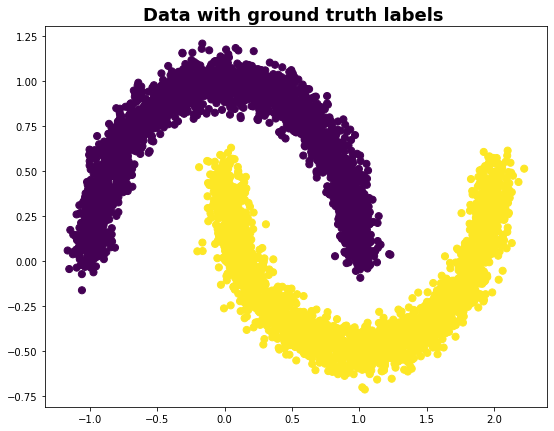

In [3]:
random_state = 21
X_mn, y_mn = make_moons(5000, noise=.07, random_state=random_state)
cmap = 'viridis'
dot_size=50

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data with ground truth labels ', fontsize=18, fontweight='demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1],c=y_mn,s=dot_size, cmap=cmap)

## Passo 1
### Hybrid Representative Selection

In [ ]:
def getRepresentivesByRandomSelection(data, pSize):
    N = data.shape[0]
    if pSize > N:
        pSize = N
    
    selectIdx = np.random.permutation(np.arange(N))[:pSize]
    randSelect = []
    for i in selectIdx:
        randSelect.append(data[i,:])

    return np.array(randSelect)

def getRepresentativesByHybridSelection(data, pSize, cntTimes=10):
    N = data.shape[0]
    bigPSize = cntTimes * pSize
    
    if pSize > N: 
        pSize = N
    if bigPSize > N: 
        bigPSize = N

    #random selection
    np.random.seed(time.time())
    RbigPdata = getRepresentivesByRandomSelection(data, bigPSize)
    
    #KNN selection

    

    return RPdata

## Passo 2
### Approximation of K-Nearest Representatives

## Passo 3
### Bipartite Graph Partitioning